In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import csv

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
path = '/g/data/w48/kb6999'

In [4]:
!ls /g/data/w48/kb6999

 20CR_data_netcdfs
 20CR_PRATE_data_for_plots
 20CR_PRATE_members
 20CR_PRATE_raw_data_for_plots
 20CR_PRATE_raw_members
 20CR_PRATE_seasonal_data_for_plots
 20CR_PRATE_seasonal_members
 20CR_TMP_data_for_plots
 20CR_TMP_members
 20CR_TMP_raw_data_for_plots
 20CR_TMP_raw_members
 20CR_TMP_seasonal_data_for_plots
 20CR_TMP_seasonal_members
 abram2014sam_data.txt
 abram2014sam.txt
 CRUTEM.4.6.0.0.anomalies.nc
 HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc
 MSLP_mon.nc
 Observations
 old_notebooks
'read&write_20CR_PR_members_2021.04.27.ipynb'
 R_K_timeseries_DJF_pr.png
 R_K_timeseries_DJF_tmp.png
 R_K_timeseries_JJA_pr.png
 R_K_timeseries_JJA_tmp.png
 R_K_timeseries_mon_pr.png
 R_K_timeseries_mon_pr_roll12.png
 R_K_timeseries_mon_pr_rolling3-6-12-24.png
 R_K_timeseries_mon_pr_rolling6.png
 R_K_timeseries_mon_SAM.png
 R_K_timeseries_mon_tmp.png
 R_K_timeseries_mon_tmp_rolling3-6-12-24.png
 R_K_timeseries_mon_tmp_rolling3-6-12.png
 R_K_timeseries_mon_tmp_rolling6-12.png
 R_K_timeserie

## skip this section as the below cells read in the data and save as netcdf (which has already been done)

In [5]:
# read in daily mean sea level pressure (mean across all 20CR members)
P_df = pd.read_csv(f'{path}/abram2014sam_data.txt', delimiter='\t')
# set the date as teh index column
P_df = P_df.set_index(['age_AD'])
P_df

,SAM_Index,SAM_Index_err,RE,RE_crit,SAM_Index_70yloess,SAM_Index_+error_70yloess,SAM_Index_-error_70yloess,Marshall_SAM_Index
age_AD,,,,,,,,
2007,-2.655296,3.217976,-0.015027,-0.237163,1.815786,4.752763,-1.119229,-0.083
2006,2.516332,3.217976,-0.015027,-0.237163,1.762162,4.682995,-1.156849,2.197
2005,0.250082,3.236963,-0.027041,-0.115012,1.708567,4.613422,-1.194603,0.987
2004,2.043958,3.236963,-0.027041,-0.115012,1.655018,4.544066,-1.232481,1.857
2003,0.834730,3.236963,-0.027041,-0.115012,1.601538,4.474956,-1.270464,1.037
...,...,...,...,...,...,...,...,...
1004,-1.813489,3.011280,0.111179,0.006600,-1.579751,1.431294,-4.590993,NaN
1003,-1.529136,3.011280,0.111179,0.006600,-1.563468,1.447598,-4.574714,NaN
1002,-1.007336,3.011280,0.111179,0.006600,-1.548646,1.462439,-4.559895,NaN


In [6]:
# convert to xarra
P_xr = P_df.to_xarray()
P_xr

<xarray.Dataset>
Dimensions:                    (age_AD: 1008)
Coordinates:
  * age_AD                     (age_AD) int64 2007 2006 2005 ... 1002 1001 1000
Data variables:
    SAM_Index                  (age_AD) float64 -2.655 2.516 ... -1.524 -3.22
    SAM_Index_err              (age_AD) float64 3.218 3.218 ... 3.011 3.011
    RE                         (age_AD) float64 -0.01503 -0.01503 ... 0.1112
    RE_crit                    (age_AD) float64 -0.2372 -0.2372 ... 0.0066
    SAM_Index_70yloess         (age_AD) float64 1.816 1.762 ... -1.536 -1.524
    SAM_Index_+error_70yloess  (age_AD) float64 4.753 4.683 ... 1.476 1.487
    SAM_Index_-error_70yloess  (age_AD) float64 -1.119 -1.157 ... -4.547 -4.535
    Marshall_SAM_Index         (age_AD) float64 -0.083 2.197 0.987 ... nan nan

In [7]:
# rename age to time
P_time = P_xr.rename({'age_AD':'time'})
# reorder time from smallest to largest
P_time = P_time.sortby('time', ascending=True)
P_time

<xarray.Dataset>
Dimensions:                    (time: 1008)
Coordinates:
  * time                       (time) int64 1000 1001 1002 ... 2005 2006 2007
Data variables:
    SAM_Index                  (time) float64 -3.22 -1.524 ... 2.516 -2.655
    SAM_Index_err              (time) float64 3.011 3.011 3.011 ... 3.218 3.218
    RE                         (time) float64 0.1112 0.1112 ... -0.01503
    RE_crit                    (time) float64 0.0066 0.0066 ... -0.2372 -0.2372
    SAM_Index_70yloess         (time) float64 -1.524 -1.536 ... 1.762 1.816
    SAM_Index_+error_70yloess  (time) float64 1.487 1.476 1.462 ... 4.683 4.753
    SAM_Index_-error_70yloess  (time) float64 -4.535 -4.547 ... -1.157 -1.119
    Marshall_SAM_Index         (time) float64 nan nan nan ... 0.987 2.197 -0.083

In [9]:
# select out years from 1850-present
start_date, end_date = '1850','2007'
P_final = P_time.sel(time=slice(start_date, end_date))
time = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='YS')
P_final['time'] = time
P_final

<xarray.Dataset>
Dimensions:                    (time: 158)
Coordinates:
  * time                       (time) datetime64[ns] 1850-01-01 ... 2007-01-01
Data variables:
    SAM_Index                  (time) float64 -0.5283 -1.041 ... 2.516 -2.655
    SAM_Index_err              (time) float64 2.318 2.318 2.318 ... 3.218 3.218
    RE                         (time) float64 0.4734 0.4734 ... -0.01503
    RE_crit                    (time) float64 0.2604 0.2604 ... -0.2372 -0.2372
    SAM_Index_70yloess         (time) float64 -0.6394 -0.6412 ... 1.762 1.816
    SAM_Index_+error_70yloess  (time) float64 1.688 1.687 1.687 ... 4.683 4.753
    SAM_Index_-error_70yloess  (time) float64 -2.966 -2.968 ... -1.157 -1.119
    Marshall_SAM_Index         (time) float64 nan nan nan ... 0.987 2.197 -0.083

In [10]:
# convert to netcdf
with dask.diagnostics.ProgressBar():
    P_final.to_netcdf(f'{path}/SAM_data_abram_1850_2007.nc')

P*40�S and P*65�S are the normalized monthly zonal sea level pressure (SLP) at 40�S and 65�S
The 30-year period from 1971-2000 is used for the normalization period. Note that this period is arbitrary and a switch to a different period would change the exact SAM values but would be unlikely to significantly alter any trends.
(true zonal mean was simply the mean of the 144 points along the appropriate parallel)

# need to normalise P40 and should probs save PRMSL monthly as a netcdf and also maybe SAM

In [11]:
# read in netcdf of monthly pressure
SAM_abram = xr.open_dataset('SAM_data_abram_1850_2007.nc')
SAM_abram

<xarray.Dataset>
Dimensions:                    (time: 158)
Coordinates:
  * time                       (time) datetime64[ns] 1850-01-01 ... 2007-01-01
Data variables:
    SAM_Index                  (time) float64 ...
    SAM_Index_err              (time) float64 ...
    RE                         (time) float64 ...
    RE_crit                    (time) float64 ...
    SAM_Index_70yloess         (time) float64 ...
    SAM_Index_+error_70yloess  (time) float64 ...
    SAM_Index_-error_70yloess  (time) float64 ...
    Marshall_SAM_Index         (time) float64 ...

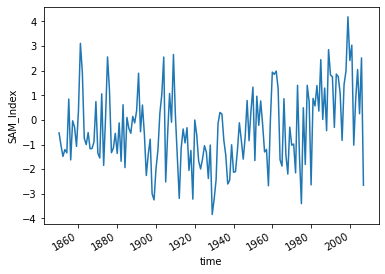

In [13]:
SAM_abram.SAM_Index.sel(time=slice(start_date, end_date)).plot()

# figures

In [14]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [15]:
e_date = ['1883-08-27']

[Text(-5479.0, 0, '1955'),
 Text(-3653.0, 0, '1960'),
 Text(-1826.0, 0, '1965'),
 Text(0.0, 0, '1970'),
 Text(1826.0, 0, '1975'),
 Text(3652.0, 0, '1980'),
 Text(5479.0, 0, '1985'),
 Text(7305.0, 0, '1990'),
 Text(9131.0, 0, '1995'),
 Text(10957.0, 0, '2000'),
 Text(12784.0, 0, '2005')]

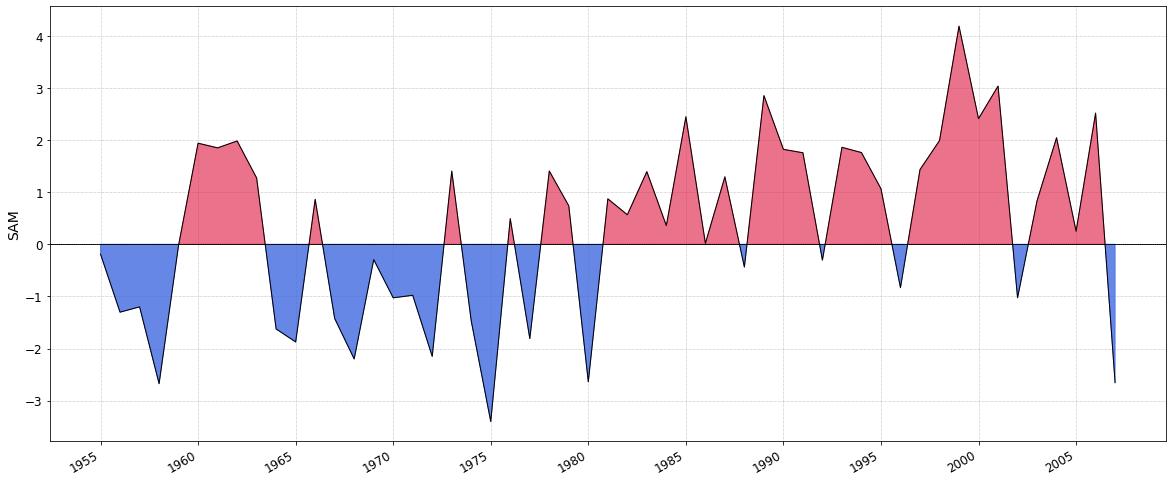

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))

# select the dataset and years to plot
start_date, end_date = '1955','2007'
ds = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))

# plot the SAM index
fplot.SAM_plot(ds, ax = axes)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='5YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

# plt.savefig('R_timeseries_mon_SAM_compare.png', dpi=300, bbox_inches='tight')

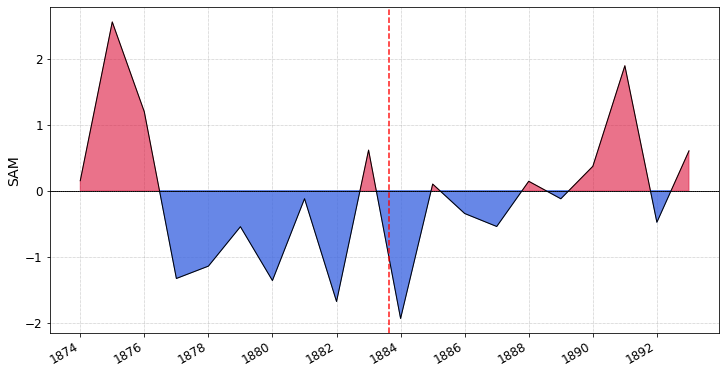

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))

# select the dataset and years to plot
start_date, end_date = '1873-08','1893-08'
ds = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))

# plot the SAM index
fplot.SAM_plot(ds, ax = axes, e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='2YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

plt.savefig('R_K_timeseries_SAM_Abram.png', dpi=300, bbox_inches='tight')

Negative SAM: westerly winds further north than usual.  This brings more precipitation to southwest and southeast in winter and less precipitation in parts of the east, so it is likely to be wetter in Victoria, but dry in New South Wales. There is also an increased chance of snow in alpine areas.  In summer, a negative SAM causes a decreased likelihood of precipitation in the southeast and east and a greater chance of spring heatwaves in sourthern australia.  Th
In EL Ninos SAM tends to be more negative particularly in spring and summer. This enhances El Nino signals.    

(citation: http://www.bom.gov.au/climate/sam/#tabs=What-is-SAM%3F) 

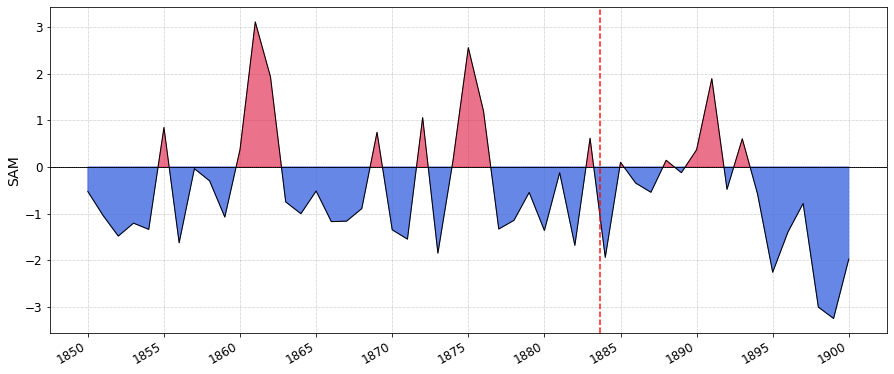

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(15,6))

# select the dataset and years to plot
start_date, end_date = '1850-01','1900-01'
ds = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))

# plot the SAM index
fplot.SAM_plot(ds, ax = axes, e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='5YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

plt.savefig('R_timeseries_SAM_Abram.png', dpi=300, bbox_inches='tight')